#(Easy) High performance text processing in Machine Learning*

#ML meetup
##*Joint work with Ian Langmore


#[Rosetta*](https://github.com/columbia-applied-data-science/rosetta) 
###(*created with Ian Langmore; contributors include Matt DeLand, Thomas Nyberg, et al)

##Tools for data science with a focus on text processing.

* Focuses on "medium data", i.e. data too big to fit into memory but too small to necessitate the use of a cluster.
* Integrates with existing scientific Python stack as well as select outside tools.

## Tools and utilities 

### `cmd` 
* Unix-like command line utilities.  Filters (read from stdin/write to stdout) for files

### `parallel` 
* Wrappers for Python multiprocessing that add ease of use
* Memory-friendly multiprocessing

### `text`
* Stream text from disk to formats used in common ML processes
    * file, database, and generic streamers
* Write processed text to sparse formats
* Helpers for ML tools (e.g. Vowpal Wabbit, Gensim, etc...)
* Other general utilities

### `workflow`
* High-level wrappers that have helped with our workflow and provide additional examples of code use

### `modeling`
* General ML modeling utilities


#Lets begin

###for the purpose of this tutorial we will be working with a collection of about 1000 declassified government embassy cables
* you can replace the data with any top-directory of text files or you really want this particular data set feel free to email me and I'll send "Declassification Engine" REST API documentation


In [5]:
import os
import pandas as pd

#Text Processors

##Streamers
* Data in many text processing problems comes in the form of 
    * flat files
    * repeated calls to an DB or API
    * some 'online' stream
* A lot of these can be handled streaming the data either from disk, DB, API minimizing CPU use
* In addition, a lot of streaming is embarassingly parallel so can be easily scaled


In [6]:
#all you realy need to know is that CABLES is the directory where the data (or cables)
#are stored on your machine
DATA = os.environ['DATA']
CABLES = os.path.join(DATA, 'declass', 'cables_short')
RAW = os.path.join(CABLES, 'raw')
PROCESSED = os.path.join(CABLES, 'processed')
SPARSE = os.path.join(CABLES, 'sparse')

sfile_path = os.path.join(SPARSE, 'cables-short.vw')
filtered_sfile_path = os.path.join(PROCESSED, 'cables-short-filtered.vw')
sff_path = os.path.join(PROCESSED, 'sff.pkl')

## Streaming: given a collection of objects streaming is the paradigm of processing these objects one at a time in memory, extracting relevant information, writing the information, and discarding the original object 

###Note: after a streaming process is complete, the original collection should no longer be needed for the analysis at hand

* Lets write a simple file streamer

In [7]:
#filefilter is a module which helps with basic file/dir functions, such as
#retrieving all paths from a given directory and it's subdir's
from rosetta.text import filefilter

In [8]:
def simple_file_streamer(base_path):
    paths = filefilter.get_paths(base_path, get_iter=True)
    for p in paths:
        with open(p) as f:
            text = f.read()
            yield(text)

###In case you haven't worked much with iterators explicitely, here is a small refresher... 
* For those familiar with generator functions, or iterators, you'll notice that this is exactly what we mean by "streamer," i.e. anything that retrieves files or extracts information from therein and has a .next() method
* python docs have a short intro about generators (http://docs.python.org/2/tutorial/classes.html#generators)

In [9]:
def my_iter(N):
    i=0
    while True:
        if i == N:
            raise StopIteration
        else:
            yield i
        i += 1
                
        

In [10]:
mi = my_iter(5)



In [11]:
mi.next()

0

In [12]:
#note the raised StopIteration; lets see how a for look handles this

for i in my_iter(5):
    print i
    

0
1
2
3
4


###so even if you have not thought about iterators, you have been using them throughout 
###now back to our streamer

In [13]:
simple_stream = simple_file_streamer(RAW)

In [14]:
#lets look at what this object is
type(simple_stream)

generator

###Note: this is the first time anything is read into memory

In [15]:
#lets see what the .next() yields (and splitlines to make it more readable)
simple_stream.next().splitlines()

['UNCLASSIFIED',
 '',
 'PAGE 01        ACCRA  01284  091110Z',
 'ACTION OCS-06',
 '',
 'INFO  OCT-00   ADS-00   AF-10    AMAD-01  CA-01    /018 W',
 '                    ------------------203337  091121Z /38',
 'O 081104Z FEB 73',
 'FM AMEMBASSY ACCRA',
 'TO AMEMBASSY MONROVIA IMMEDIATE',
 'INFO SECSTATE WASHDC 4185',
 'AMEMBASSY ABIDJAN',
 '',
 'UNCLAS ACCRA 01284',
 '',
 'E.O. 12356: N/A',
 'TAGS: CASC (AKINS, ESTHER)',
 'SUBJ: WELFARE/WHEREABOUTS: ESTHER AKINS',
 '',
 'REF: MONROVIA 01199 (NOTAL)',
 '',
 '1. MS. AKINS LAST REGISTERED WITH THE EMBASSY ON MARCH 23,',
 '1981.  SHE LATER REPORTED SHE WAS DUE TO LEAVE GHANA ON',
 'MARCH 2, 1982.',
 '',
 '2. ATTEMPTS TO REACH HER BY PHONE THROUGH THE INSTITUTE',
 'OF LINGUISTICS, HER CONTACT ADDRESS AT THE TIME OF HER',
 '1981-82 STAY IN GHANA AND OTHER MISSIONARIES HAS PROVED',
 'UNSUCCESSFUL.  THE SOURCE OF LIGHT MISSION IS NOT, RPT NOT,',
 'KNOWN TO US.',
 '',
 '3. WE WILL MAKE ADDITIONAL EFFORTS TO LOCATE MS. AKINS,',
 'AND WILL INFOR


* Now since our end goal is to build a topic model we probably want to have a more fexible streamer, i.e. one that can return file ids, text or tokens (based on some predefined tokenizer)
    * luckily we have one such streamer written

In [16]:
from rosetta import TextFileStreamer, TokenizerBasic
text_streamer = TextFileStreamer(text_base_path=RAW, file_type='*', 
                                           tokenizer=TokenizerBasic())


In [17]:
from rosetta.text import streamers

In [18]:
stream = text_streamer.info_stream()

In [20]:
stream.next()

{'atime': 1399823974.0,
 'cached_path': '/Users/danielkrasner/DATA_master/prod/declass/cables_short/raw/1976YAOUND00800',
 'doc_id': '1976YAOUND00800',
 'mtime': 1383854248.0,
 'size': 475,
 'text': 'UNCLASSIFIED\n\nPAGE 01  YAOUND 00800  030654Z\n\n20\nACTION CU-04\n\nINFO  OCT-01  AF-06  ISO-00  USIA-15  /026 W\n                       ---------------------     100150\nR 021600Z MAR 76\nFM AMEMBASSY YAOUNDE\nTO SECSTATE WASHDC 7937\n\nUNCLAS YAOUNDE 0800\n\nFOR CU/AF\n\nE.O. 11652: N/A\nTAGS: OEXC EIV ETRD\nSUBJ: MULTI-REGIONAL PROJECT ON INTERNATIONAL INVESTMENT,\n       MARCH 21 TO APRIL 19, 1976\n\nREF: STATE 044439\n\nPOST REGRETS UNABLE NOMINATE CANDIDATE.\nSPIRO\n\n\nUNCLASSIFIED\n\n\n\n\nNNN',
 'tokens': ['unclassified',
  'page',
  'yaound',
  'action',
  'cu',
  'info',
  'oct',
  'af',
  'iso',
  'usia',
  'mar',
  'fm',
  'amembassy',
  'yaounde',
  'secstate',
  'washdc',
  'unclas',
  'yaounde',
  'e.o',
  'tags',
  'oexc',
  'eiv',
  'etrd',
  'subj',
  'multi',
  'regio

* Note: you can pass a tokenizer function to TextFileStreamer(), i.e. any function that takes a string of text and returns a list of strings (the "tokens")
    * We have written a basic tokenizer function and class to add functionality and because the nltk.word_tokenize() was slow
* It also has a few other nice options such as shuffle, file_type, etc and a bunch of methods

In [26]:
text = stream.next()['text']

In [27]:
print text

UNCLASSIFIED

PAGE 01  ZAGREB 00018  121152Z

44
ACTION VOE-00

INFO  OCT-01  ISO-00  /001 W
                       ---------------------     058313
R 081530Z JAN 76
FM AMCONSUL ZAGREB
TO SECSTATE WASHDC 3529

UNCLAS ZAGREB 0018

E.O. 11652:  N/A
TAGS:  CVIS  YO
SUBJECT:  FS-258, DEC. 1975

1. PLEASE CORRECT FS-258 DEC. 1975.  FIVE IR-5 ISSUED, INSTEAD
OF THREE AS REPORTED.  THAT CHANGES THE TOTAL TO 32 INSTEAD OF
30.  KAISER


UNCLASSIFIED




NNN


In [28]:
text_streamer.tokenizer.text_to_token_list(text)
#text_streamer.tokenizer.text_to_counter(text)

['unclassified',
 'page',
 'zagreb',
 'action',
 'voe',
 'info',
 'oct',
 'iso',
 'jan',
 'fm',
 'amconsul',
 'zagreb',
 'secstate',
 'washdc',
 'unclas',
 'zagreb',
 'e.o',
 'tags',
 'cvis',
 'yo',
 'subject',
 'fs',
 'dec',
 'please',
 'correct',
 'fs',
 'dec',
 'five',
 'ir',
 'issued',
 'instead',
 'three',
 'reported',
 'changes',
 'total',
 'instead',
 'kaiser',
 'unclassified',
 'nnn']

In [41]:
#lets look at a few methods
token_stream = text_streamer.token_stream() # returns a generator function which yields a stream of tokens

In [42]:
token_stream.next()[:10] # this is what our basic tokenizer returns (we are skipping stop words and numerics by default)

['unclassified',
 'page',
 'zagreb',
 'action',
 'scse',
 'info',
 'oct',
 'iso',
 'oct',
 'fm']

text_streamer.doc_id # returns a list of retrieved doc ids etc 


In [43]:
#if you want to use another tokenizer it's easy
import nltk
nltk.word_tokenize(text)
text_streamer_nltk = TextFileStreamer(text_base_path=RAW, file_type='*', 
                                      tokenizer_func=nltk.word_tokenize)

In [44]:
stream_nltk = text_streamer_nltk.token_stream()

In [45]:
stream_nltk.next()[:10]

['CONFIDENTIAL',
 'PAGE',
 '01',
 'ZANZIB',
 '00033',
 '091100Z',
 '44',
 'ACTION',
 'AF-06',
 'INFO']

#Vowpal Wabbit for LDA Topic Modeling
* LDA = Latent Dirichlet Allocation 
    * treats each document as a bag of words 
    * a topic is chosen from a topic distribution $p(k)$ where $k=1, \dots , K$
    * a word is chosen from the k'th topic distribution $p(w|k)$ and thrown into the bag
    * distrubutions $p(k)$ depends on $\theta$ ~ $Dir(\alpha)$ and $p(w|k)$ depends on $\beta$ a $k\times V$ matrix of word probabilties
        * these 'latent' variables are chosen to maximize the probability of producing the observed documents, and in turn depend on user chosen parameters $\alpha$ and $\eta$ 
    * the model produces two important probability distributions:
        * $p(w|k)$, the probability of $w$ bring generated by topic $k$ and
        * $p(k|d)$, the probabilty of topic $k$ being used to generate a randomly chosen word from document $d$ 
    * these topic and word weights can be used to understand the semantic structure of the documents as well as generate document feature
    * for more details about LDA topic modeling see the wonderful Blei, Ng, and Jordan [paper](http://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf)
* Vowpal Wabbit
    * optimized (very fast) C++ library http://hunch.net/~vw/
    * can find tutorials at https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial and 
    https://github.com/columbia-applied-data-science/rosetta/blob/master/examples/vw_helpers.md
    




In [46]:
from rosetta.text import text_processors, filefilter, streamers, vw_helpers

In [47]:
#create the VW format file 
my_tokenizer = text_processors.TokenizerBasic()
stream = streamers.TextFileStreamer(text_base_path=RAW, tokenizer=my_tokenizer)
stream.to_vw(sfile_path, n_jobs=-1, raise_on_bad_id=False)

In [ ]:
### somewhere here run (stick with 5 passes or so...)
# rm -f *cache
#vw --lda 20 --cache_file doc_tokens.cache --passes 5 -p prediction.dat --readable_model topics.dat --bit_precision 16 --lda_D 975 --lda_rho 0.1 --lda_alpha 1 ../sparse/cables-short.vw


In [48]:
#load the sparse file 
formatter = text_processors.VWFormatter()
sff = text_processors.SFileFilter(formatter)
sff.load_sfile(sfile_path)

In [49]:
#remove "gaps" in the sequence of numbers (ids)
sff.compactify()
sff.save(PROCESSED + '/sff_basic.pkl')

Compactification done.  self.bit_precision_required = 14
collisions = 0, vocab_size = 14476
All collisions resolved


In [52]:
sff.to_frame().sort_index(by='doc_fraction', ascending=False).head(10)

doc_freq  token_score  doc_fraction
token                                        
fm             829          845      0.849385
page           829         1325      0.849385
action         829          907      0.849385
info           829         1432      0.849385
oct            829          973      0.849385
iso            828          852      0.848361
secstate       827          854      0.847336
washdc         824          907      0.844262
nnn            819          830      0.839139
tags           782          785      0.801230

[10 rows x 3 columns]

## Look at LDA results

In [53]:
#use the LDAResults class from rosetta to convert back to readable, python friendly formats
lda = vw_helpers.LDAResults(PROCESSED + '/topics.dat', 
                            PROCESSED + '/prediction.dat', PROCESSED + '/sff_basic.pkl')

In [54]:
#look at some of the words
topic_words = lda.pr_token_g_topic.loc[:,'topic_12'].order(ascending=False).index[:10]
lda.sfile_frame.loc[topic_words]

doc_freq  token_score  doc_fraction
token                                            
woulb                1            1      0.001025
rescheduling         1            1      0.001025
inherent             1            1      0.001025
wise                 1            1      0.001025
flags                1            1      0.001025
ekstrom              2            2      0.002049
letting              1            1      0.001025
consultation        14           17      0.014344
miles                2            2      0.002049
frontmen             1            1      0.001025

[10 rows x 3 columns]

In [75]:
#look at the the first topic
a_topic = lda.pr_token_g_topic.T.loc['topic_00'].copy()
a_topic.sort(ascending=False)
a_topic[:10]

token
racunskih     0.020413
png'ing       0.019496
redirect      0.001991
perkovic      0.001038
investors     0.000777
generous      0.000718
rectifying    0.000718
libyans       0.000718
horvat        0.000718
foregoing     0.000718
Name: topic_00, dtype: float64

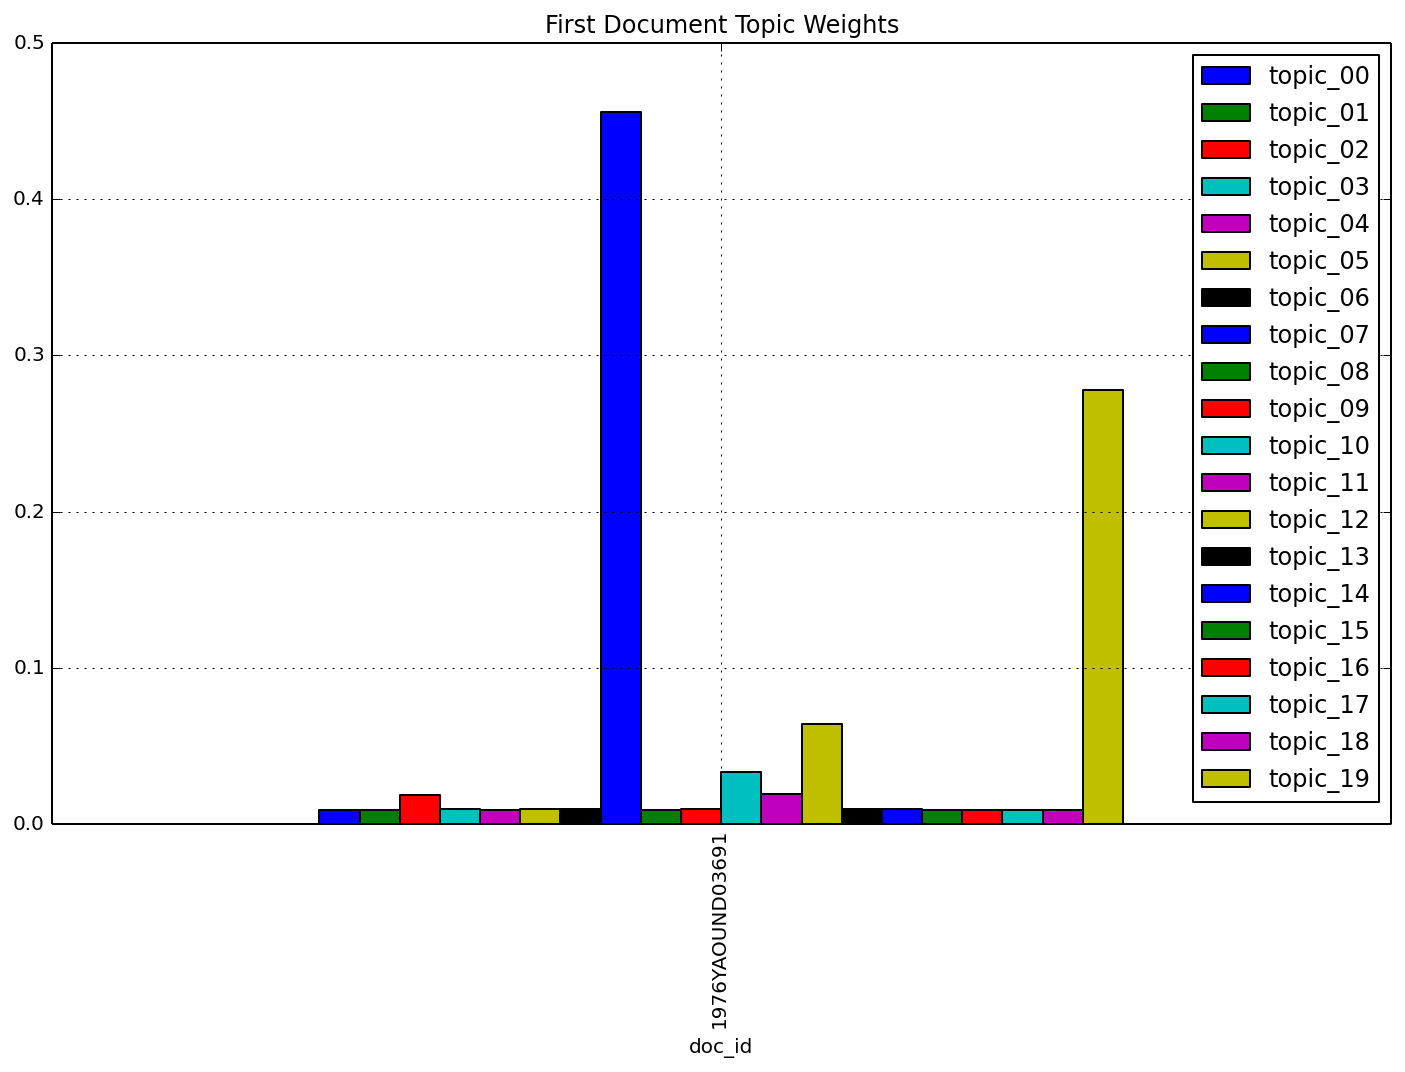

In [81]:
##
lda.pr_topic_g_doc.T.loc[[0]].plot(kind='bar', figsize=(12,7),
                                   title = 'First Document Topic Weights')

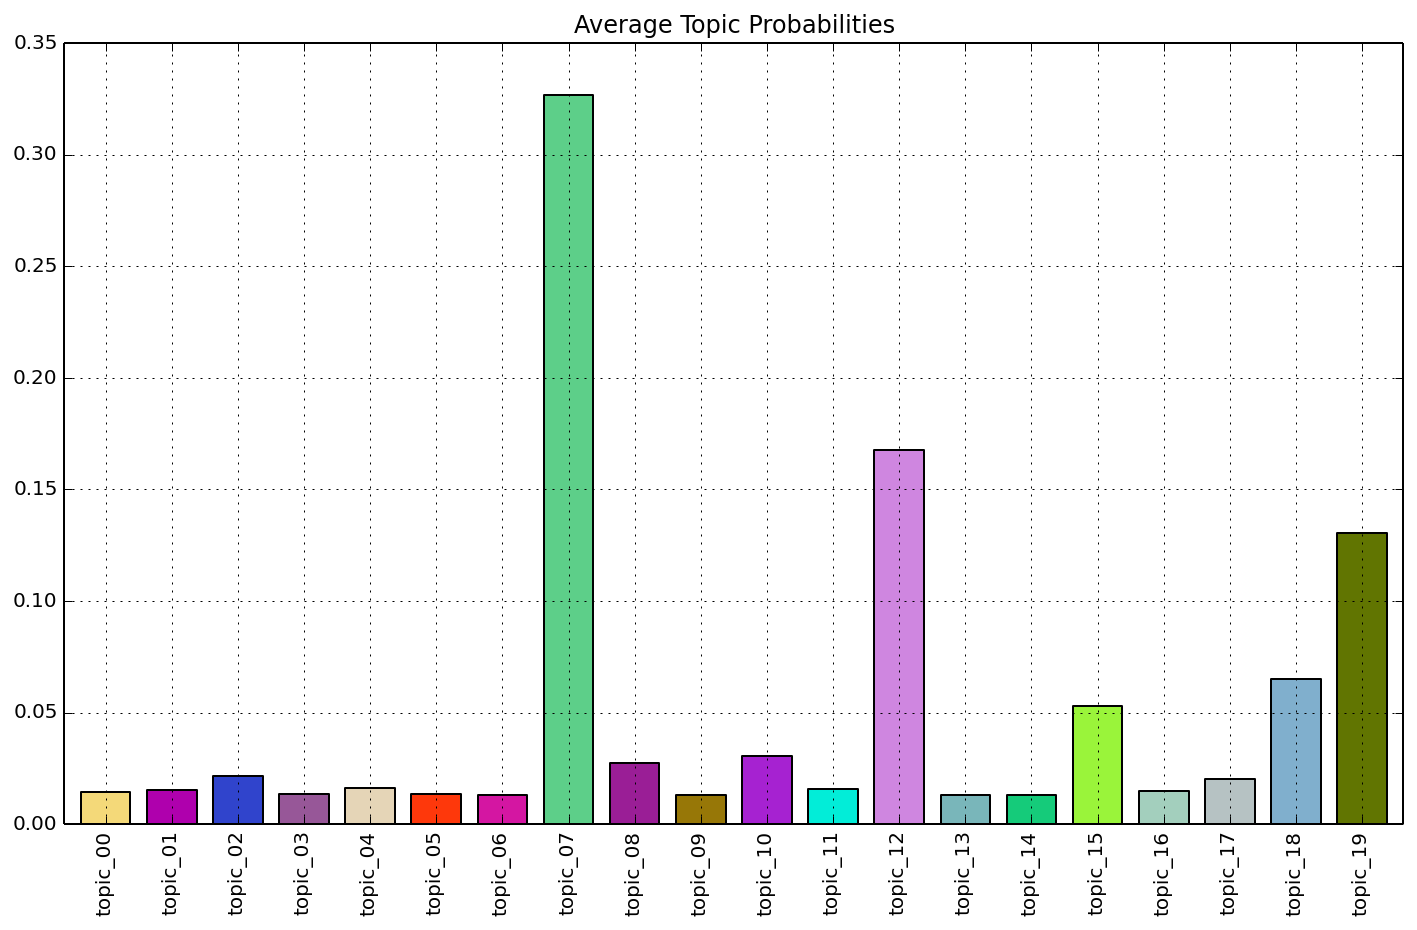

In [82]:
#or at the average topic probabilties 
import random
r = lambda: random.randint(0,255)
my_colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(20)]
#my_colors = 'rgbkymc'
lda.pr_topic_g_doc.mean(axis=1).plot(kind='bar', figsize=(12,7), color=my_colors,
                                     title='Average Topic Probabilities')

##You can grab a copy of this [notebook](https://github.com/columbia-applied-data-science/rosetta/tree/master/notebooks) in the [Rosetta repo](https://github.com/columbia-applied-data-science/rosetta). 



##[Declassification Engine](declassification-engine.org)
    * https://github.com/declassengine/declass
    * email if interested in participating
    
##[Rosetta](https://github.com/columbia-applied-data-science/rosetta)
    *Install, fork, submnit issues, contribute!








#Have fun!



#contact: daniel@kfitsolutions.com